# Temporal and enviromental patterns in SARS-Cov-2 sequences

Finding patterns in genomic sequence that can be interpreted into temporal or environmental variables is a task of continuous research. Those findings could lead to a better understanding of the evolution of an organism. The following contains the training of a machine learning model for a representation learning task.  And how to combine those representations with different environmental variables.

In [1]:
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from Bio import SeqIO
from io import StringIO

from sklearn import preprocessing as pr
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.layers import Conv2D,  Dense, Layer, BatchNormalization
from tensorflow.keras.layers import Flatten, Reshape, Dropout, LayerNormalization, GlobalAveragePooling1D


globalSeed=768
from numpy.random import seed 
seed(globalSeed)
tf.compat.v1.set_random_seed(globalSeed)

# Kmer size determination 

The use of kmer is one of the backbones of alignment-free methods, Kmers represents short fragments of sequences where k stands for the fragment size. Those fragments represent a sample of the sequence and one of the main questions in this kind of analysis is to determine the appropriate size of the Kmer. One method will be to analyze the number of unique Kmers that result by splitting the sequence into K size fragments. This shows two behaviors, a sigmoid behavior for small k followed by a monotonous decline in the number of unique fragments. Thus, most of the variability inside the sequence can be captured by relatively small Kmers. 

In [2]:
def GetSeqs(Dir):
    
    cDir=Dir
    
    with open(cDir) as file:
        
        seqData=file.read()
        
    Seq=StringIO(seqData)
    SeqList=list(SeqIO.parse(Seq,'fasta'))
    
    return SeqList 

In [3]:
seqs = GetSeqs('../input/covid19-sequences/sequences.fasta')

## Number of Unique k-mers 



In [4]:
testSeq = seqs[0].seq
nseq = len(testSeq)
containerForward = []
containerReverse = []

for k in range(15):
    localSeq = [testSeq[j:j+k+1] for j in range(nseq-k+1)]
    ratio = len(set(localSeq))/nseq
    containerForward.append(ratio)
    
for k in range(0,nseq,100):
    localSeq = [testSeq[j:j+k+1] for j in range(nseq-k+1)]
    ratio = len(set(localSeq))/nseq
    containerReverse.append(ratio)

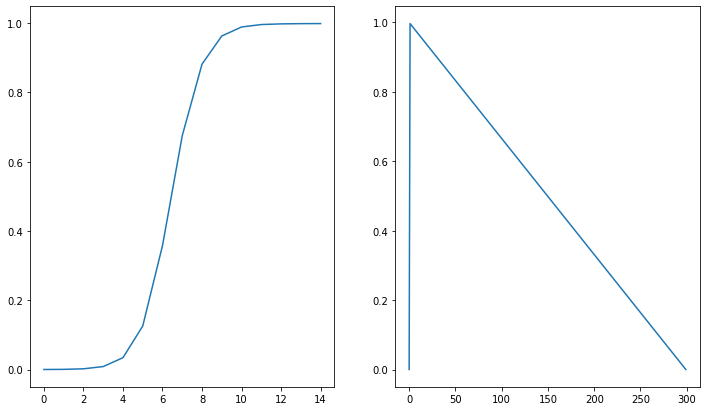

In [5]:
fig,axs = plt.subplots(1,2,figsize=(12,7))

_ = axs[0].plot(containerForward)
_ = axs[1].plot(containerReverse)

# Metadata

From the metadata, we can see that there's a huge imbalance in the number of sequences isolated and sequenced between the first and second years of the pandemic. To prevent any effect of the unbalance into the resulting representations the data is resampled to try to obtain an even distribution. However, this subsampling will be made at the week level, trying to have the same number of samples for each week. The number of samples per week will be based on the peaks of the first year of the pandemic. 

In [6]:
def GetSampleLoc(Sample,boundaries):
    cLoc=0
    for k in range(len(boundaries)-1):
        if Sample>=boundaries[k] and Sample<boundaries[k+1]:
            cLoc=k
            break
        
    return cLoc

def GetEqualizedIndex(Data,bins=100,maxCount=100):
  
    cMin,cMax=np.min(Data),np.max(Data)
    boundaries=np.linspace(cMin,cMax,num=bins+1)
  
    SamplesCount=np.zeros(bins)
    indexContainer = []
  
    index=[k for k in range(len(Data))]
    np.random.shuffle(index)
  
    for val in index:
        dataPoint = Data.iloc[val]
        cLoc=GetSampleLoc(dataPoint,boundaries)
      
        if SamplesCount[cLoc]<=maxCount:
            indexContainer.append(val)
            SamplesCount[cLoc]=SamplesCount[cLoc]+1
      
    return indexContainer

In [7]:
MetaData = pd.read_csv(r'../input/covid19-metadata/SARSCov2Metadata.csv')
MetaData.drop(['PCA_A','PCA_B','VAE_A','VAE_B','ConvVAE_A','ConvVAE_B',],axis=1,inplace=True)
MetaData.fillna(0,inplace=True)
MetaData = MetaData[MetaData['SimplifiedGEO']=="USA"]

reSamplingIndex = GetEqualizedIndex(MetaData['outbreaktime'],bins=100,maxCount=2000)

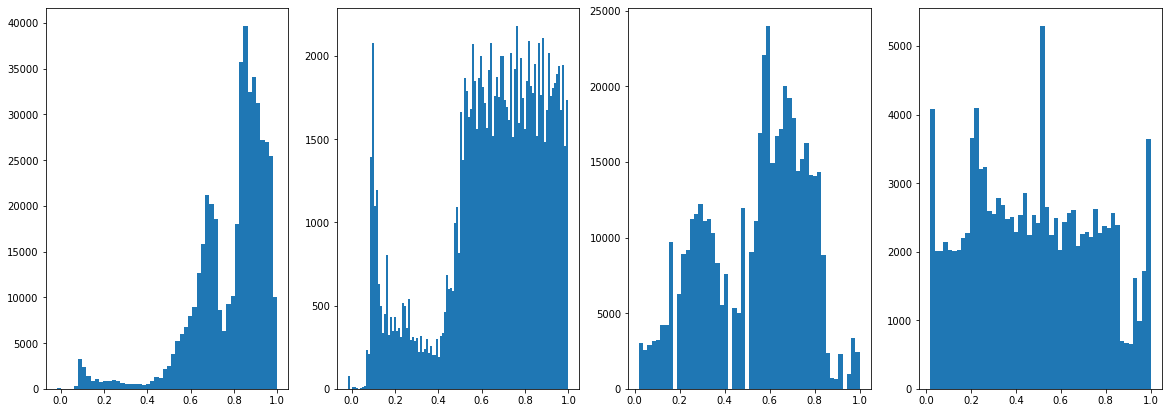

In [8]:
fig,axs = plt.subplots(1,4,figsize=(20,7))

_ = axs[0].hist(MetaData['outbreaktime'],bins=52)
_ = axs[1].hist(MetaData['outbreaktime'].iloc[reSamplingIndex],bins=110)
_ = axs[2].hist(MetaData['week'],bins=52)
_ = axs[3].hist(MetaData['week'].iloc[reSamplingIndex],bins=50)

## Data 

Sequence identifiers are used to select the selected sequences from the subsampling. Each row in the data set contains the frequency of the different Kmers sets. From the 1-mer up to the 5-mer , thus each sequence is represented by a vector of 1364 values. 

In [9]:
SampledData = MetaData.iloc[reSamplingIndex]

DataIDS = pd.read_csv('../input/covid19-sequences-extended/KmerDataExt.csv',usecols=['id'])

IdToLoc = dict([(sal[0:-2],val+1) for val,sal in zip(np.arange(len(DataIDS)-1),DataIDS['id'])])

SelectedLocs = []
for val in SampledData['id']:
    if val in IdToLoc.keys():
        SelectedLocs.append(IdToLoc[val])
        
ExcludeRowsIndex = list(set(np.arange(len(DataIDS)))-set(SelectedLocs))
ExcludeRowsIndex.pop(0)

DataSet = pd.read_csv('../input/covid19-sequences-extended/KmerDataExt.csv',skiprows=ExcludeRowsIndex)
DataSet['id'] = [val[0:-2] for val in DataSet['id']]
DataSet = DataSet.set_index('id')
DataSet

A         C         T         G        AA        AC  \
id                                                                     
OK441086  0.299351  0.183111  0.321541  0.195997  0.096432  0.067378   
OK441104  0.299380  0.182900  0.321676  0.196044  0.096402  0.067364   
OK441134  0.299363  0.183065  0.321395  0.196177  0.096418  0.067409   
OK441139  0.299391  0.183002  0.321584  0.196023  0.096445  0.067354   
OK441143  0.299290  0.183085  0.321673  0.195952  0.096341  0.067288   
...            ...       ...       ...       ...       ...       ...   
MZ331714  0.298477  0.183508  0.321659  0.196357  0.095216  0.067570   
MZ331854  0.298581  0.183187  0.321928  0.196303  0.095407  0.067496   
MZ331858  0.298550  0.183460  0.321743  0.196248  0.095260  0.067602   
MZ331867  0.298502  0.183619  0.321626  0.196253  0.095418  0.067668   
MZ331941  0.298603  0.183663  0.321309  0.196426  0.095331  0.067753   

                AT        AG        CA        CC  ...     GGGCT     GGGCG  \
id                                                ...                       
OK441086  0.077420  0.058073  0.069387  0.029555  ...  0.000469  0.000100   
OK441104  0.077423  0.058143  0.069443  0.029306  ...  0.000469  0.000101   
OK441134  0.077336  0.058153  0.069321  0.029445  ...  0.000470  0.000101   
OK441139  0.077430  0.058115  0.069329  0.029526  ...  0.000469  0.000100   
OK441143  0.077542  0.058073  0.069499  0.029355  ...  0.000469  0.000101   
...            ...       ...       ...       ...  ...       ...       ...   
MZ331714  0.077501  0.058210  0.069650  0.029491  ...  0.000470  0.000101   
MZ331854  0.077460  0.058204  0.069643  0.029286  ...  0.000470  0.000101   
MZ331858  0.077437  0.058237  0.069683  0.029471  ...  0.000470  0.000101   
MZ331867  0.077220  0.058183  0.069578  0.029628  ...  0.000469  0.000067   
MZ331941  0.077259  0.058280  0.069835  0.029493  ...  0.000470  0.000101   

             GGGTA     GGGTC     GGGTT     GGGTG     GGGGA     GGGGC  \
id                                                                     
OK441086  0.000435  0.000033  0.000703  0.000670  0.000134  0.000167   
OK441104  0.000436  0.000034  0.000704  0.000671  0.000134  0.000168   
OK441134  0.000436  0.000034  0.000704  0.000671  0.000101  0.000168   
OK441139  0.000435  0.000033  0.000703  0.000670  0.000134  0.000167   
OK441143  0.000436  0.000034  0.000704  0.000670  0.000101  0.000168   
...            ...       ...       ...       ...       ...       ...   
MZ331714  0.000436  0.000034  0.000705  0.000705  0.000134  0.000168   
MZ331854  0.000403  0.000034  0.000705  0.000738  0.000101  0.000168   
MZ331858  0.000436  0.000034  0.000705  0.000705  0.000101  0.000168   
MZ331867  0.000436  0.000034  0.000704  0.000737  0.000101  0.000168   
MZ331941  0.000437  0.000034  0.000705  0.000672  0.000134  0.000168   

             GGGGT     GGGGG  
id                            
OK441086  0.000167  0.000033  
OK441104  0.000168  0.000034  
OK441134  0.000168  0.000034  
OK441139  0.000167  0.000033  
OK441143  0.000168  0.000034  
...            ...       ...  
MZ331714  0.000168  0.000034  
MZ331854  0.000168  0.000034  
MZ331858  0.000168  0.000034  
MZ331867  0.000168  0.000034  
MZ331941  0.000168  0.000034  

[121051 rows x 1364 columns]

# Network

Applying an MLP architecture to the data will result in a high number of parameters due to the size of the data. But the data can be reshaped to form a 2D array of size 37, this results in a small size image. This enables the use of different image recognition architectures to what is essentially tabular data. To continue with the MLP theme, the autoencoder will consist of a series of stacked MLP mixers with a spatial attention layer in between each downsampling operation. And KL loss is annealed with a cyclic sigmoid scheme

## Layers

In [10]:
class KLDivergenceLayer(Layer):
    '''
    Custom KL loss layer
    '''
    def __init__(self,*args,**kwargs):
        self.annealing = tf.Variable(0.,dtype=tf.float32,trainable = False)
        self.is_placeholder=True
        super(KLDivergenceLayer,self).__init__(*args,**kwargs)
        
    def call(self,inputs):
        
        Mu,LogSigma=inputs
        klbatch=-0.5*self.annealing*K.sum(1+LogSigma-K.square(Mu)-K.exp(LogSigma),axis=-1)
        self.add_loss(K.mean(klbatch),inputs=inputs)
        self.add_metric(klbatch,name='kl_loss',aggregation='mean')
        
        return inputs

class Sampling(Layer):
    '''
    Custom sampling layer
    '''
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def get_config(self):
        config = {}
        base_config = super().get_config()
        return {**base_config, **config}
    
    @tf.autograph.experimental.do_not_convert   
    def call(self,inputs,**kwargs):
        
        Mu,LogSigma=inputs
        batch=tf.shape(Mu)[0]
        dim=tf.shape(Mu)[1]
        epsilon=K.random_normal(shape=(batch,dim))

        return Mu+(K.exp(0.5*LogSigma))*epsilon

class SpatialAttention(Layer):
    '''
    Custom Spatial attention layer
    '''
    
    def __init__(self,size, **kwargs):
        super(SpatialAttention, self).__init__()
        self.size = size
        self.kwargs = kwargs

    def build(self, input_shapes):
        self.conv = Conv2D(filters=1, kernel_size=self.size, strides=1, padding='same')

    def call(self, inputs):
        pooled_channels = tf.concat(
            [tf.math.reduce_max(inputs, axis=3, keepdims=True),
            tf.math.reduce_mean(inputs, axis=3, keepdims=True)],
            axis=3)

        scale = self.conv(pooled_channels)
        scale = tf.math.sigmoid(scale)

        return inputs * scale
    

class Patches(Layer):
    '''
    Taken from
    https://keras.io/examples/vision/mlp_image_classification/
    '''
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches
        
    @tf.autograph.experimental.do_not_convert
    def call(self, images,**kwargs):
        
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches


class MLPMixerLayer(Layer):
    '''
    Taken from
    https://keras.io/examples/vision/mlp_image_classification/
    '''
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super(MLPMixerLayer, self).__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                Dense(units=num_patches),
                BatchNormalization(),
                tfa.layers.GELU(approximate=True),
                BatchNormalization(),
                Dense(units=num_patches),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                Dense(units=num_patches),
                BatchNormalization(),
                tfa.layers.GELU(approximate=True),
                Dense(units=hidden_units),
                BatchNormalization(),
            ]
        )
        self.normalize = LayerNormalization(epsilon=1e-6)
    
    @tf.autograph.experimental.do_not_convert
    def call(self, inputs,**kwargs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x


## Autoencoder bottleneck

In [11]:
#Wrapper function, creates a small Functional keras model 
#Bottleneck of the variational autoencoder 
def MakeVariationalNetwork(Latent):
    
    InputFunction=Input(shape=(Latent,))
    Mu=Dense(Latent)(InputFunction)
    LogSigma=Dense(Latent)(InputFunction)
    Mu,LogSigma=KLDivergenceLayer()([Mu,LogSigma])
    Output=Sampling()([Mu,LogSigma])
    variationalBottleneck=Model(inputs=InputFunction,outputs=Output)
    
    return InputFunction,variationalBottleneck

def MakeBottleneck(InputShape,Latent,UpSampling=False):
    '''
    Parameters
    ----------
    InputShape : tuple
        input shape of the previous convolutional layer.
    Latent : int
        Dimentionality of the latent space.
    UpSampling : bool, optional
        Controls the sampling behaviour of the network.
        The default is False.

    Returns
    -------
    InputFunction : Keras functional model input
        input of the network.
    localCoder : Keras functional model
        Coder model, transition layer of the bottleneck.

    '''
    
    Units=[np.product(InputShape),Latent]
    
    if UpSampling:
        finalUnits=Units[::-1]
        InputFunction=Input(shape=(Latent,))
        X=Dense(finalUnits[0],use_bias=False)(InputFunction)
    
    else:
        finalUnits=Units
        InputFunction=Input(shape=InputShape)
        X=Flatten()(InputFunction)
        X=Dense(finalUnits[0],use_bias=False)(X)
                
    
    X=BatchNormalization()(X)
    X=Activation('relu')(X)
    X=Dense(finalUnits[1],use_bias=False)(X)
    X=BatchNormalization()(X)
    
    if UpSampling:
        X=Activation('relu')(X)
        Output=Reshape(InputShape)(X)
    else:
        Output=Activation('relu')(X)
        
    Bottleneck=Model(inputs=InputFunction,outputs=Output)
    
    return InputFunction,Bottleneck


## Variational autoencoder

In [12]:
def MakeMixerBlock(inputs,blocks,patch_size,num_patches,embedding_dim,dropout_rate):
    '''
    Parameters
    ----------
    inputs : keras layer
        Input of the mixer block.
    blocks : keras sequential model
        mixer blocks.
    patch_size : int
        size of the image patch, same for each dimention.
    num_patches : int
        number of patches per image.
    embedding_dim : int
        size of the embedding dimention in the mixer block.
    dropout_rate : float
        droput rate in the mixer block.

    Returns
    -------
    representation : keras layer 
        DESCRIPTION.

    '''
    
    patches = Patches(patch_size, num_patches)(inputs)
    x = Dense(units=embedding_dim,use_bias=False)(patches)
    x = blocks(x)
    x = GlobalAveragePooling1D()(x)
    x = BatchNormalization()(x)
    reshapeDim = np.sqrt(embedding_dim).astype(int)
    representation = Reshape((reshapeDim,reshapeDim,1))(x)
    
    return representation

def MakeMixerCoder(InputShape,Units,NumBlocks,DropoutRate=0.2,UpSampling=False):
    '''
    Parameters
    ----------
    InputShape : tuple
        Input shape of the network.
    Units : array-like
        Contains the dimentionality of the embedding dimentions.
    NumBlocks : int
        Number of mixer blocks.
    DropoutRate : float, optional
        Dropout rate of the mixer block. The default is 0.2.
    PatchSize : int, optional
        size of the segmented patch in the image. The default is 4.
    UpSampling : bool, optional
        Controls the upsamplig or downsampling behaviour of the network.
        The default is False.

    Returns
    -------
    InputFunction : Keras functional model input
        input of the network.
    localCoder : Keras functional model
        Coder model, main body of the autoencoder.

    '''
    
    if UpSampling:
        EmbeddingDimentions=Units[::-1]
    else:
        EmbeddingDimentions=Units
        
    currentSize = np.sqrt(EmbeddingDimentions[0]).astype(int)
    PatchSize = currentSize//2
    num_patches = (currentSize//PatchSize)**2
    
    InputFunction = Input(shape = InputShape)
    X = SpatialAttention(3)(InputFunction)
    X = BatchNormalization()(X)
    MBlocks = keras.Sequential(
        [MLPMixerLayer(num_patches, EmbeddingDimentions[0], DropoutRate) for _ in range(NumBlocks)]
        )
    
    X = MakeMixerBlock(X,MBlocks,PatchSize,num_patches,EmbeddingDimentions[0],DropoutRate)

    for k in range(1,len(EmbeddingDimentions)):
        
        currentSize = np.sqrt(EmbeddingDimentions[k-1]).astype(int)
        PatchSize = currentSize//2
        num_patches = (currentSize//PatchSize)**2
        
        X = SpatialAttention(3)(X)
        X = BatchNormalization()(X)
        MBlocks =  keras.Sequential(
            [MLPMixerLayer(num_patches, EmbeddingDimentions[k], DropoutRate) for _ in range(NumBlocks)]
            )
        X = MakeMixerBlock(X,MBlocks,PatchSize,num_patches,EmbeddingDimentions[k],DropoutRate)
        

    if UpSampling:
        Output = Activation('sigmoid')(X)
        localCoder = Model(inputs=InputFunction,outputs=Output)
        
    else:
        localCoder = Model(inputs=InputFunction,outputs=X)
    
    return InputFunction,localCoder

#Wrapper function joins the Coder function and the bottleneck function 
#to create a simple autoencoder
def MakeMixerAutoencoder(InputShape,Units,BlockSize):
    
    InputEncoder,Encoder=MakeMixerCoder(InputShape,Units,BlockSize)
    #Encoder.summary()
    EncoderOutputShape=Encoder.layers[-1].output_shape
    BottleneckInputShape=EncoderOutputShape[1::]
    InputBottleneck,Bottleneck=MakeBottleneck(BottleneckInputShape,2)
    ConvEncoderOutput=Bottleneck(Encoder(InputEncoder))
    
    ConvEncoder=Model(inputs=InputEncoder,outputs=ConvEncoderOutput)
    
    rInputBottleneck,rBottleneck=MakeBottleneck(BottleneckInputShape,2,UpSampling=True)
    InputDecoder,Decoder=MakeMixerCoder(BottleneckInputShape,Units,BlockSize,UpSampling=True)
    ConvDecoderOutput=Decoder(rBottleneck(rInputBottleneck))
    ConvDecoder=Model(inputs=rInputBottleneck,outputs=ConvDecoderOutput)
    
    ConvAEoutput=ConvDecoder(ConvEncoder(InputEncoder))
    ConvAE=Model(inputs=InputEncoder,outputs=ConvAEoutput)
    
    return InputEncoder,InputDecoder,ConvEncoder,ConvDecoder,ConvAE

# Wrapper functon, joins the autoencoder function with the custom variational
#layers to create an autoencoder
def MakeMixerVariationalAutoencoder(InputShape,Units,BlockSize):
    
    InputEncoder,InputDecoder,ConvEncoder,ConvDecoder,_=MakeMixerAutoencoder(InputShape,Units,BlockSize)
    
    InputVAE,VAE=MakeVariationalNetwork(2)
    VAEencoderOutput=VAE(ConvEncoder(InputEncoder))
    ConvVAEencoder=Model(inputs=InputEncoder,outputs=VAEencoderOutput)
    
    VAEOutput=ConvDecoder(ConvVAEencoder(InputEncoder))
    ConvVAEAE=Model(inputs=InputEncoder,outputs=VAEOutput)
    
    return InputEncoder,InputDecoder,ConvVAEencoder,ConvDecoder,ConvVAEAE


## Auxiliary functions

In [13]:
class KLAnnealing(keras.callbacks.Callback):

    def __init__(self,position, weigths):
        super().__init__()
        self.position = position
        self.weigths = tf.Variable(weigths,trainable=False,dtype=tf.float32)

    def on_epoch_end(self, epoch,logs=None):
        
        weights = self.model.get_weights()
        weights[self.position] = self.weigths[epoch]
        self.model.set_weights(weights)

def MakeAnnealingWeights(epochs,cycles,scale=1):
    
    pointspercycle = epochs//cycles
    AnnealingWeights = 1*(1/(1+np.exp(-1*np.linspace(-10,10,num=pointspercycle))))
    
    for k in range(cycles-1):
        AnnealingWeights = np.append(AnnealingWeights,1*(1/(1+np.exp(-1*np.linspace(-10,10,num=pointspercycle+1)))))
        
    return scale*AnnealingWeights

# Training

## Data split

In [14]:
trainIndex,testIndex,_,_ = train_test_split(DataSet.index,DataSet.index,test_size=0.1,random_state=23)
DataLabels = [val for val in list(DataSet) if val not in ['id']]

## Network hyperparameters

In [15]:
Arch = [37**2,(37//2)**2,(37//4)**2,(37//8)**2]
    
lr=0.00075
minlr=0.000001  
epochs=125
batch_size = 256
decay=2*(lr-minlr)/epochs
inShape = (37,37,1)
sh = 0.00001
AnnealingWeights = MakeAnnealingWeights(epochs,7,scale=sh)

_,_,Encoder,Decoder,AE=MakeMixerVariationalAutoencoder(inShape,Arch,1)
AE.summary()

2022-02-19 19:18:34.702446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 19:18:34.821236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 19:18:34.822382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 19:18:34.825048: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 37, 37, 1)]       0         
_________________________________________________________________
model_8 (Functional)         (None, 2)                 590192    
_________________________________________________________________
model_5 (Functional)         (None, 37, 37, 1)         151039    
Total params: 741,231
Trainable params: 726,630
Non-trainable params: 14,601
_________________________________________________________________


## K fold cross validation

In [16]:
ModelsContainer = []
HistoryContainer = []
Scalers = []
nfolds = 5

kf = KFold(n_splits=nfolds,shuffle=True,random_state=44)

for train_index, test_index in kf.split(trainIndex):
    
    trainLabels,testLabels = np.array(trainIndex)[train_index],np.array(trainIndex)[test_index]
    
    Xtrain, Xtest = DataSet.loc[trainLabels][DataLabels], DataSet.loc[testLabels][DataLabels]
    
    scaler = pr.MinMaxScaler()
    scaler.fit(Xtrain)
    
    Xtrain = scaler.transform(Xtrain)
    Xtest = scaler.transform(Xtest)
    
    Scalers.append(scaler)
    
    Xtrain = np.array([np.array(list(val)+[0,0,0,0,0]).reshape((37,37)) for val in Xtrain]).reshape((-1,37,37,1))
    Xtest = np.array([np.array(list(val)+[0,0,0,0,0]).reshape((37,37))for val in Xtest]).reshape((-1,37,37,1))
    
    _,_,Encoder,Decoder,AE=MakeMixerVariationalAutoencoder(inShape,Arch,1) 
    
    KLAposition = [k for k,val in enumerate(AE.get_weights()) if len(val.shape)==0][0]

    AE.compile(Adam(learning_rate=lr,decay=decay),loss='mse')
    history = AE.fit(x=Xtrain,y=Xtrain,batch_size=batch_size,epochs=epochs,
                        validation_data=(Xtest,Xtest),callbacks=[KLAnnealing(KLAposition,AnnealingWeights)])
    
    ModelsContainer.append(Encoder)
    HistoryContainer.append(history)

    tf.compat.v1.set_random_seed(globalSeed)

2022-02-19 19:19:21.801912: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 477266256 exceeds 10% of free system memory.
2022-02-19 19:19:22.526963: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 477266256 exceeds 10% of free system memory.
2022-02-19 19:19:23.047333: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 477266256 exceeds 10% of free system memory.
2022-02-19 19:19:23.392025: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 477266256 exceeds 10% of free system memory.
2022-02-19 19:19:23.767925: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/125


2022-02-19 19:19:42.861932: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


341/341 [==============================] - 63s 115ms/step - loss: 0.0258 - kl_loss: 0.0000e+00 - val_loss: 0.0152 - val_kl_loss: 0.0000e+00
Epoch 2/125
341/341 [==============================] - 36s 106ms/step - loss: 0.0163 - kl_loss: 3.3159e-10 - val_loss: 0.0154 - val_kl_loss: 3.8531e-10
Epoch 3/125
341/341 [==============================] - 36s 105ms/step - loss: 0.0130 - kl_loss: 1.3372e-09 - val_loss: 0.0122 - val_kl_loss: 2.0197e-09
Epoch 4/125
341/341 [==============================] - 36s 106ms/step - loss: 0.0115 - kl_loss: 5.3957e-09 - val_loss: 0.0100 - val_kl_loss: 5.3040e-09
Epoch 5/125
341/341 [==============================] - 37s 107ms/step - loss: 0.0104 - kl_loss: 1.6023e-08 - val_loss: 0.0097 - val_kl_loss: 1.2042e-08
Epoch 6/125
341/341 [==============================] - 36s 105ms/step - loss: 0.0099 - kl_loss: 5.0087e-08 - val_loss: 0.0093 - val_kl_loss: 7.2706e-08
Epoch 7/125
341/341 [==============================] - 36s 106ms/step - loss: 0.0088 - kl_loss: 1.70

2022-02-19 20:39:41.181612: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 477266256 exceeds 10% of free system memory.


Epoch 1/125
341/341 [==============================] - 64s 115ms/step - loss: 0.0241 - kl_loss: 0.0000e+00 - val_loss: 0.0170 - val_kl_loss: 0.0000e+00
Epoch 2/125
341/341 [==============================] - 36s 105ms/step - loss: 0.0159 - kl_loss: 2.2500e-10 - val_loss: 0.0135 - val_kl_loss: 3.5063e-10
Epoch 3/125
341/341 [==============================] - 36s 105ms/step - loss: 0.0125 - kl_loss: 9.3893e-10 - val_loss: 0.0108 - val_kl_loss: 1.0706e-09
Epoch 4/125
341/341 [==============================] - 43s 127ms/step - loss: 0.0112 - kl_loss: 3.1583e-09 - val_loss: 0.0114 - val_kl_loss: 3.4505e-09
Epoch 5/125
341/341 [==============================] - 36s 106ms/step - loss: 0.0101 - kl_loss: 1.1345e-08 - val_loss: 0.0086 - val_kl_loss: 1.2884e-08
Epoch 6/125
341/341 [==============================] - 36s 106ms/step - loss: 0.0089 - kl_loss: 4.1025e-08 - val_loss: 0.0079 - val_kl_loss: 4.6831e-08
Epoch 7/125
341/341 [==============================] - 40s 117ms/step - loss: 0.0077 - k

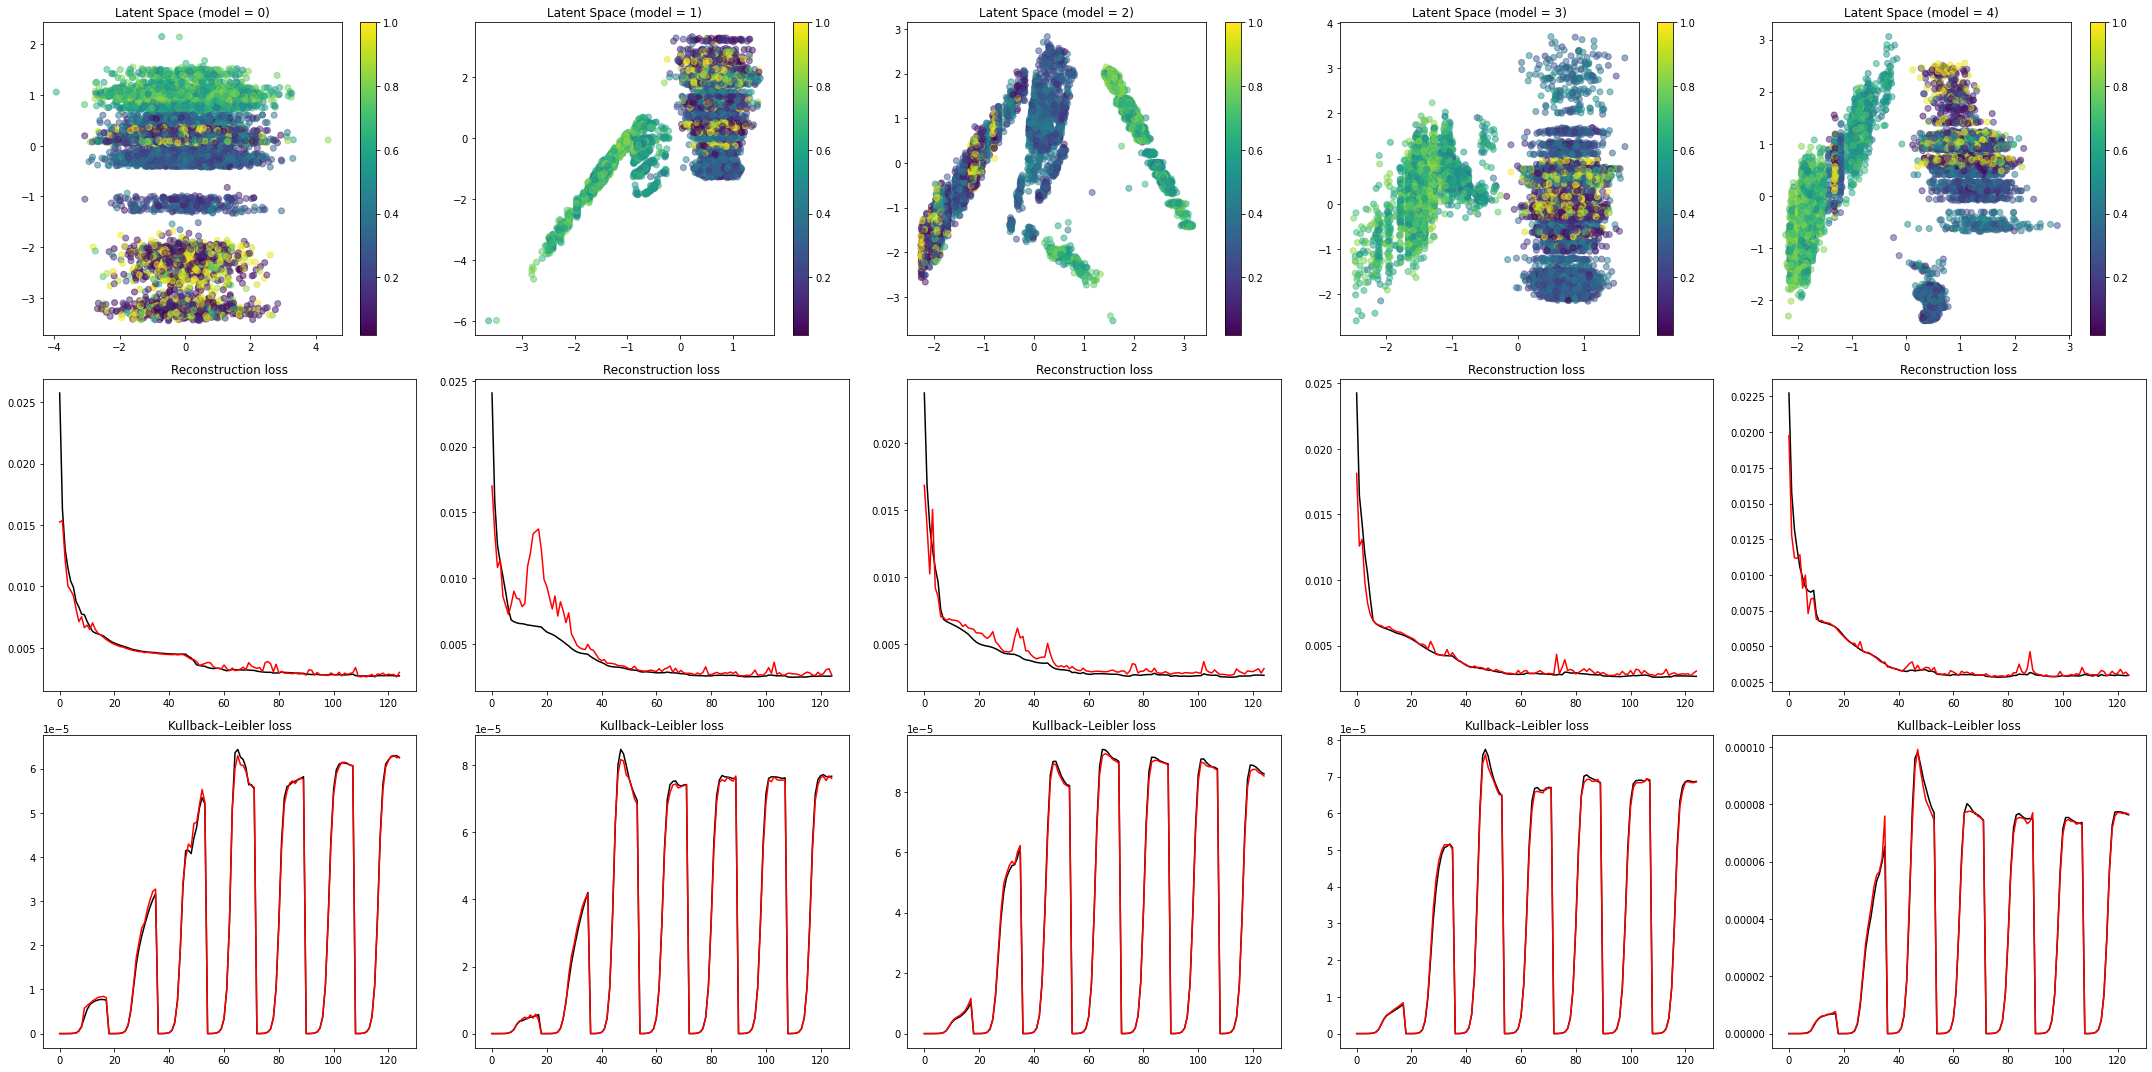

In [17]:
XtestDS = DataSet.loc[testIndex][DataLabels] 
MetaData = MetaData.set_index('id')
RepresentationContainer = []

fig,axs = plt.subplots(3,nfolds,figsize=(30,15))

for k,block in enumerate(zip(ModelsContainer,HistoryContainer,Scalers)):
    
    mod,hist,scaler = block
    localData = scaler.transform(XtestDS)
    localData = np.array([np.array(list(val)+[0,0,0,0,0]).reshape((37,37)) for val in localData]).reshape((-1,37,37,1))
    
    VariationalRepresentation = mod.predict(localData)
    RepresentationContainer.append(VariationalRepresentation)
    im = axs[0,k].scatter(VariationalRepresentation[:,0],VariationalRepresentation[:,1],c=MetaData.loc[XtestDS.index.tolist()]['week'],alpha=0.5)
    axs[0,k].title.set_text('Latent Space (model = ' + str(k) +')')
    cbar = plt.colorbar(im,ax = axs[0,k])
    cbar.solids.set(alpha=1)
    
    axs[1,k].plot(hist.history['loss'],'k-',label = 'Loss')
    axs[1,k].plot(hist.history['val_loss'],'r-',label = 'Validation Loss')
    axs[1,k].title.set_text('Reconstruction loss')
    
    axs[2,k].plot(hist.history['kl_loss'],'k-',label = 'Loss')
    axs[2,k].plot(hist.history['val_kl_loss'],'r-',label = 'Validation Loss')
    axs[2,k].title.set_text('Kullback–Leibler loss')
    
plt.tight_layout()

# Nucleotide shift

In a previous notebook, one of the characteristics inside the SARS Cov 2 sequence representation was the separation between two well-defined periods. And one of the differences between the sequences was the change in the content of Cytosine and Thymine/Uracil. Cytosine and Uracil are not complementary bases, and this shift can increase variability in the ratio of Thymine/Cytosine. 

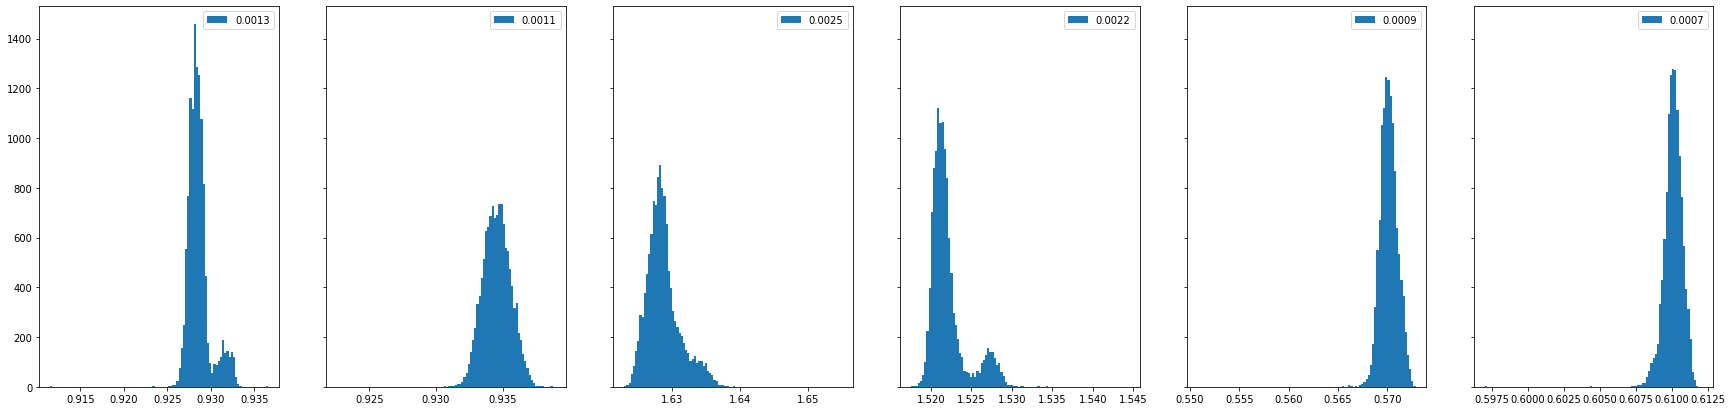

In [18]:
fig,axs = plt.subplots(1,6,figsize=(30,7),sharey=True)

ratio = XtestDS['A']/XtestDS['T']
label = round(np.std(ratio),4)
axs[0].hist(ratio,bins=100,label=str(label))
axs[0].legend()

ratio = XtestDS['C']/XtestDS['G']
label = round(np.std(ratio),4)
axs[1].hist(ratio,bins=100,label=str(label))
axs[1].legend()

ratio = XtestDS['A']/XtestDS['C']
label = round(np.std(ratio),4)
axs[2].hist(ratio,bins=100,label=str(label))
axs[2].legend()

ratio = XtestDS['A']/XtestDS['G']
label = round(np.std(ratio),4)
axs[3].hist(ratio,bins=100,label=str(label))
axs[3].legend()

ratio = XtestDS['C']/XtestDS['T']
label = round(np.std(ratio),4)
axs[4].hist(ratio,bins=100,label=str(label))
axs[4].legend()

ratio = XtestDS['G']/XtestDS['T']
label = round(np.std(ratio),4)
axs[5].hist(ratio,bins=100,label=str(label))
axs[5].legend()


The ratio between complementary bases is around one but, the standard deviation is almost twice compared to non-complementary bases. Color coding those ratios results in patterns with clear separation of high and low values.

## Cytosine - Thymine/Uracil Ratio

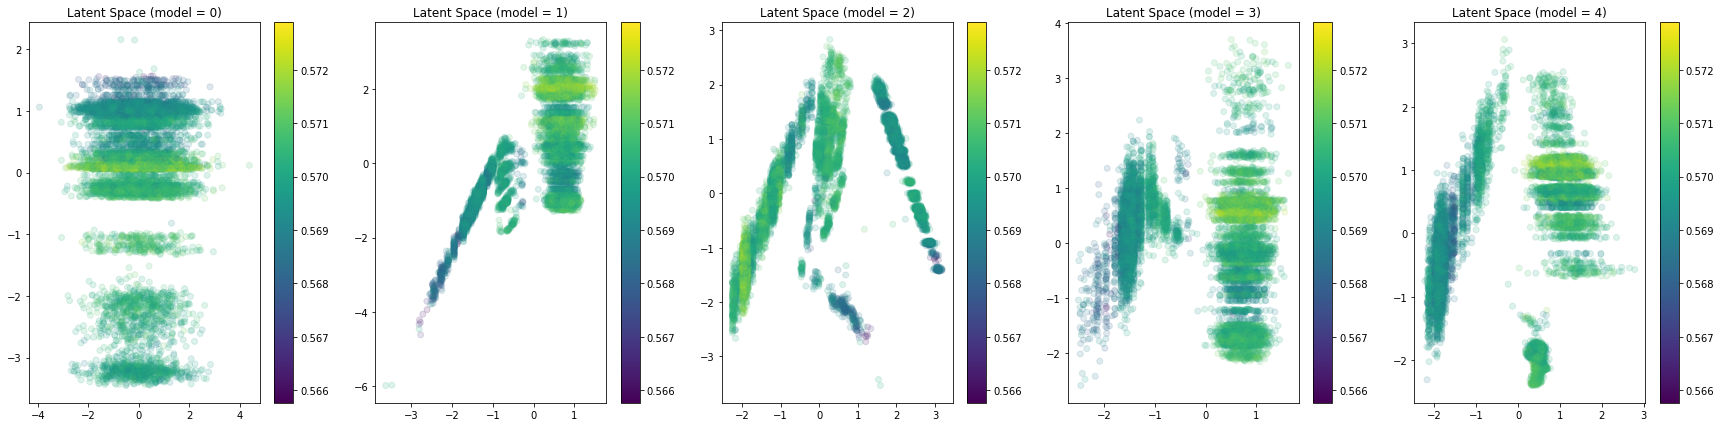

In [19]:
fig,axs = plt.subplots(1,nfolds,figsize=(30,7))

localColor = XtestDS['C']/XtestDS['T']
localMean= localColor.mean()
zscore = [(val-localColor.mean())/localColor.std() for val in localColor]
noOutliersColor = [localMean if np.abs(sal)>5 else val for val,sal in zip(localColor,zscore)]

for k,vr in enumerate(RepresentationContainer):
    
    VariationalRepresentation = vr
    im = axs[k].scatter(VariationalRepresentation[:,0],VariationalRepresentation[:,1],c=noOutliersColor,alpha=0.15)
    axs[k].title.set_text('Latent Space (model = ' + str(k) +')')
    cbar = plt.colorbar(im,ax = axs[k])
    cbar.solids.set(alpha=1)

## Guanine - Thymine/Uracil Ratio

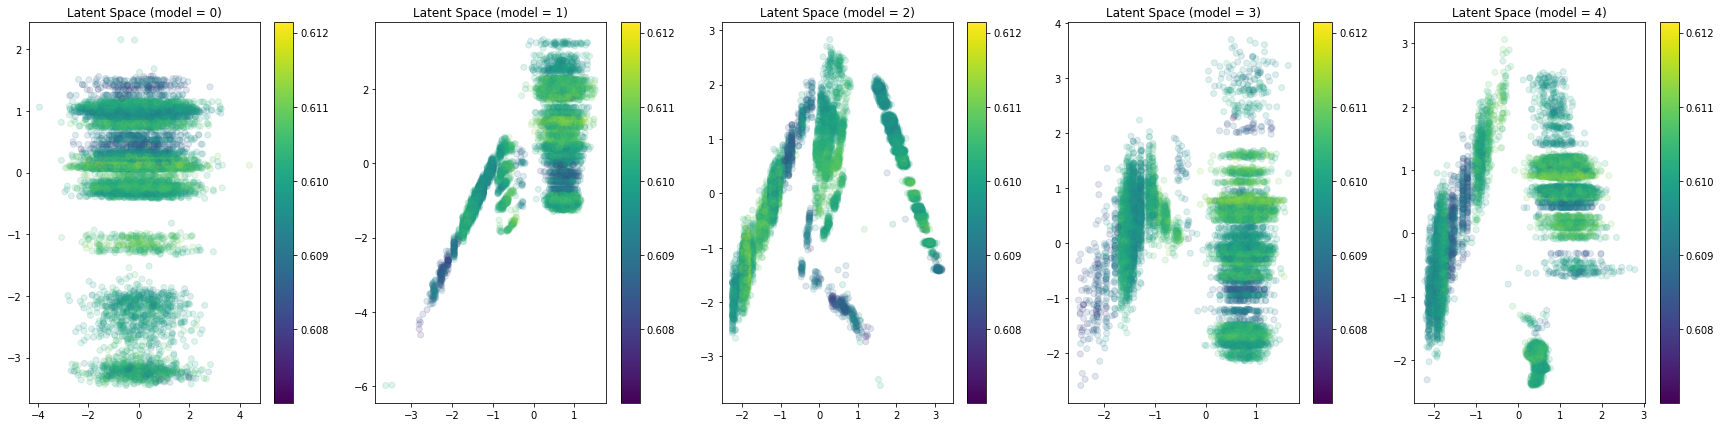

In [20]:
fig,axs = plt.subplots(1,nfolds,figsize=(30,7))

localColor = XtestDS['G']/XtestDS['T']
localMean= localColor.mean()
zscore = [(val-localColor.mean())/localColor.std() for val in localColor]
noOutliersColor = [localMean if np.abs(sal)>5 else val for val,sal in zip(localColor,zscore)]

for k,vr in enumerate(RepresentationContainer):
    
    VariationalRepresentation = vr    
    im = axs[k].scatter(VariationalRepresentation[:,0],VariationalRepresentation[:,1],c=noOutliersColor,alpha=0.15)
    axs[k].title.set_text('Latent Space (model = ' + str(k) +')')
    cbar = plt.colorbar(im,ax = axs[k])
    cbar.solids.set(alpha=1)

# Infection  Dynamics

In [21]:
USAInfectionData = pd.read_csv('../input/us-covid19-dataset-live-hourlydaily-updates/States.csv')
USAInfectionData["datets"] = pd.to_datetime(USAInfectionData['date'],format='%Y-%m-%d')
USAInfectionData["year"] = USAInfectionData["datets"].dt.year
USAInfectionData["week"] = USAInfectionData["datets"].dt.isocalendar().week
USAInfection2021 = USAInfectionData[USAInfectionData["year"]==2021]

USATotal2021 = np.array(USAInfectionData[USAInfectionData["year"]==2021].groupby('week')['cases'].sum()/USAInfectionData[USAInfectionData["year"]==2021].groupby('week')['cases'].sum().max()).reshape((-1,))

In [22]:
speed  = np.diff(USATotal2021[0:-2],n=1)
acceleration = np.diff(USATotal2021[0:-2],n=2)

speed = np.append(speed,[speed[-1],speed[-1],speed[-1],speed[-1]])
acceleration = np.append(acceleration,[acceleration[-1],acceleration[-1],acceleration[-1],acceleration[-1],acceleration[-1]])
weeks = np.sort(MetaData['week'].unique())

toSpeed = dict([(val,sal) for val,sal in zip(weeks,speed) ])
toAcceleration = dict([(val,sal) for val,sal in zip(weeks,acceleration)])

MetaData['speed'] = [toSpeed[val] for val in MetaData['week']]
MetaData['acceleration'] = [toAcceleration[val] for val in MetaData['week']]

From the infection data, two features are calculated to get a description of the infection dynamics, speed and acceleration are weighted by the number of unique variants isolated that week. Following the dynamics theme, the features are named momentum and force.

In [23]:
WeekVals = MetaData['week'].unique()
UniqueVariants = [len(set(MetaData[MetaData['week']==val]['Pangolin'])) for val in WeekVals]
MaxVariants = max(UniqueVariants)
UniqueVariants = [val/MaxVariants for val in UniqueVariants]

toVariants = dict([(val,sal) for val,sal in zip(weeks,UniqueVariants)])
toVariants[0.] = toVariants[1.]

MetaData['variants'] = [toVariants[val]/max(UniqueVariants) for val in MetaData['week']]
MetaData['mommentum'] = [val*sal for val,sal in zip(MetaData['speed'],MetaData['variants'])]
MetaData['force'] = [val*sal for val,sal in zip(MetaData['acceleration'],MetaData['variants'])]

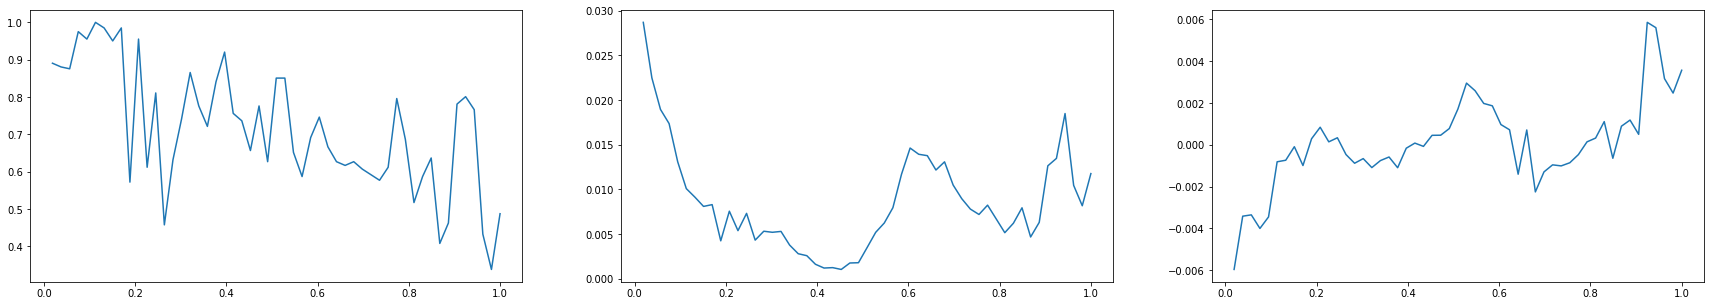

In [24]:
fig,axs = plt.subplots(1,3,figsize=(30,5))

axs[0].plot(MetaData.groupby('week')['variants'].mean())
axs[1].plot(MetaData.groupby('week')['mommentum'].mean())
axs[2].plot(MetaData.groupby('week')['force'].mean())

## Variants

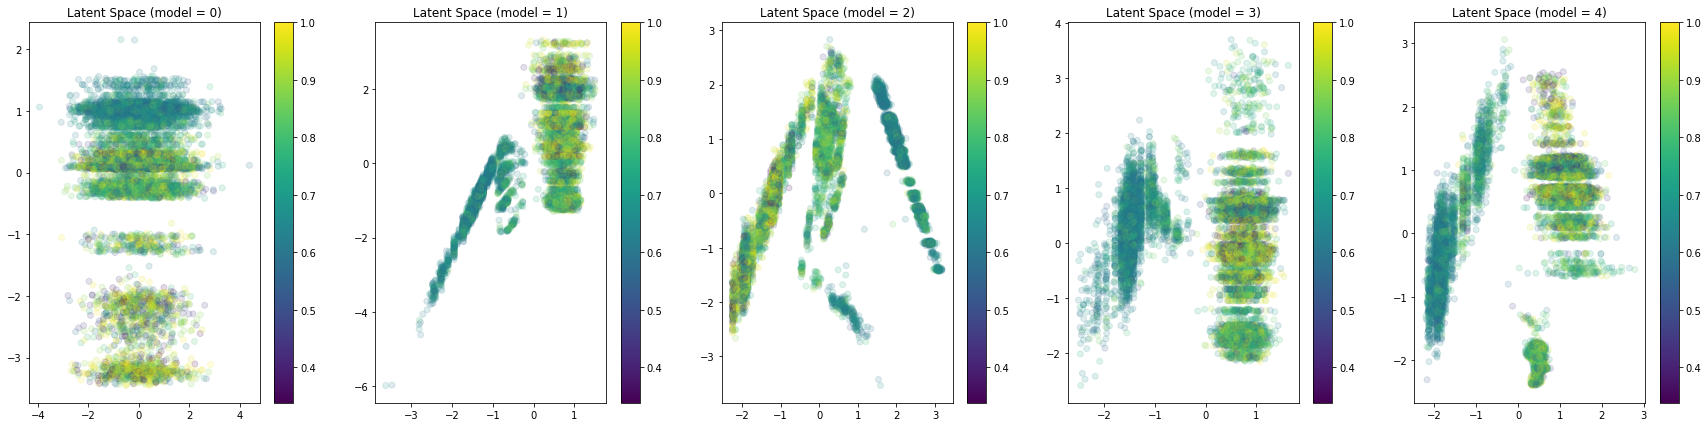

In [25]:
fig,axs = plt.subplots(1,nfolds,figsize=(30,7))

for k,vr in enumerate(RepresentationContainer):
    
    VariationalRepresentation = vr
    im = axs[k].scatter(VariationalRepresentation[:,0],VariationalRepresentation[:,1],c=MetaData.loc[XtestDS.index.tolist()]['variants'],alpha=0.15)
    axs[k].title.set_text('Latent Space (model = ' + str(k) +')')
    cbar = plt.colorbar(im,ax = axs[k])
    cbar.solids.set(alpha=1)

## Momentum

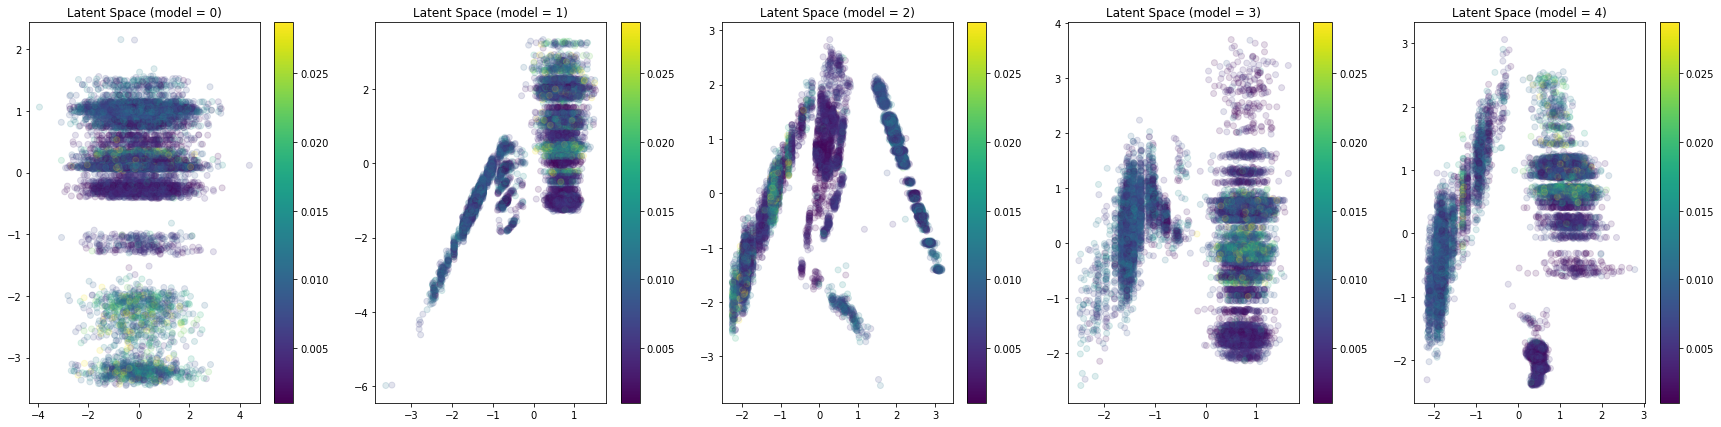

In [26]:
fig,axs = plt.subplots(1,nfolds,figsize=(30,7))

for k,vr in enumerate(RepresentationContainer):
    
    VariationalRepresentation = vr
    im = axs[k].scatter(VariationalRepresentation[:,0],VariationalRepresentation[:,1],c=MetaData.loc[XtestDS.index.tolist()]['mommentum'],alpha=0.15)
    axs[k].title.set_text('Latent Space (model = ' + str(k) +')')
    cbar = plt.colorbar(im,ax = axs[k])
    cbar.solids.set(alpha=1)

## Force

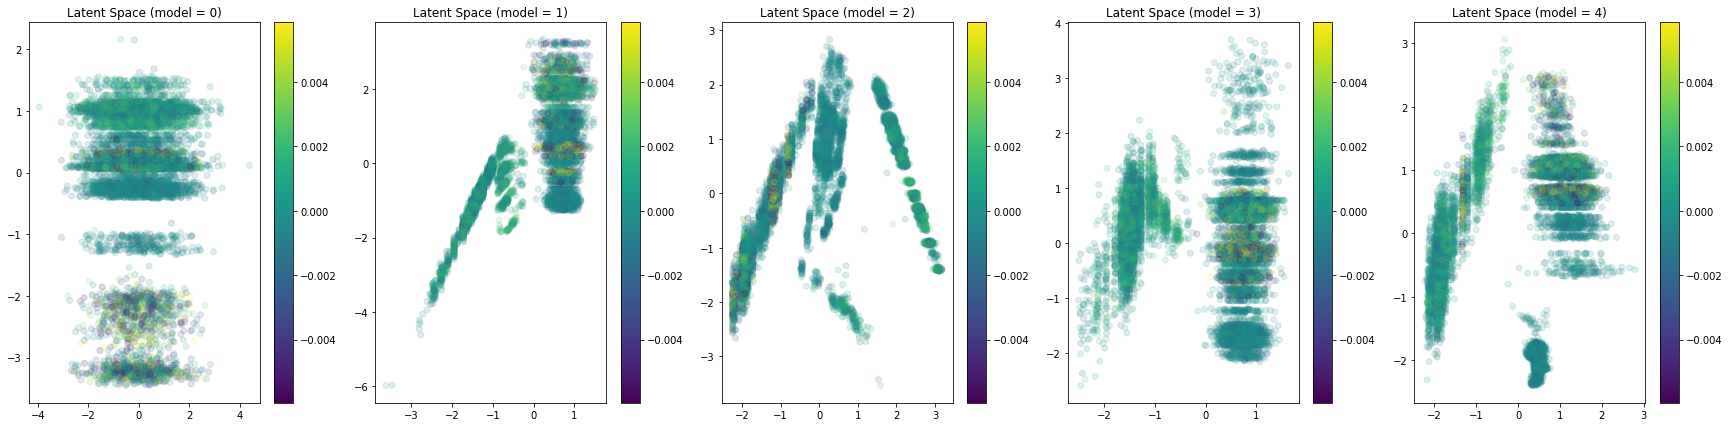

In [27]:
fig,axs = plt.subplots(1,nfolds,figsize=(30,7))

for k,vr in enumerate(RepresentationContainer):
    
    VariationalRepresentation = vr
    im = axs[k].scatter(VariationalRepresentation[:,0],VariationalRepresentation[:,1],c=MetaData.loc[XtestDS.index.tolist()]['force'],alpha=0.15)
    axs[k].title.set_text('Latent Space (model = ' + str(k) +')')
    cbar = plt.colorbar(im,ax = axs[k])
    cbar.solids.set(alpha=1)

# Enviroment

The addition of infection dynamics information helps us to try to find patterns or meanings inside the latent representation. However, the different axis might represent environmental variables. To that end, temperature, atmospheric pressure, and rainfall are added to try to find environmental patterns inside the data. From that data, the dry air density is estimated. The different environmental variables might result in insights into viral mutation or viral adaptation. 

In [28]:
locations = pd.read_csv('../input/weather-data-in-2021/locations.csv')
temperature = pd.read_csv('../input/weather-data-in-2021/temperature2021.csv')
pressure = pd.read_csv('../input/weather-data-in-2021/pressure2021.csv')
precipitation = pd.read_csv('../input/weather-data-in-2021/precipitation2021.csv')

temperature = temperature.set_index('week')
pressure = pressure.set_index('week')
precipitation = precipitation.set_index('week')

locations = locations[['geo_lat','geo_long']]
uniqueLocations = np.array([list(x) for x in set(tuple(x) for x in np.array(locations))])
locationToIndex = dict([(tuple(sal),val) for val,sal in zip(np.arange(uniqueLocations.shape[0]),uniqueLocations)])

MetaData['week'] = [int(val*53) for val in MetaData['week']]
MetaData[MetaData['week'] == 0 ]=1

In [29]:
localFrame = MetaData.loc[XtestDS.index.tolist()][['geo_lat','geo_long','week']]

temperatureTest = []
precipitationTest = []
pressureTest = []

for k,val in enumerate(np.array(localFrame)):
    location = tuple([val[0],val[1]])
    if location in locationToIndex.keys():
        index = locationToIndex[location]
        week = val[2]
        temperatureTest.append(temperature[str(index)].loc[week])
        precipitationTest.append(precipitation[str(index)].loc[week])
        pressureTest.append(pressure[str(index)].loc[week])
    else:
        temperatureTest.append(temperature.loc[week].mean())
        precipitationTest.append(precipitation.loc[week].mean())
        pressureTest.append(pressure.loc[week].mean())
        
DryAirDensity = [val/(287.05*(sal+273)) for val,sal in zip(pressureTest,temperatureTest)]

## Temperature

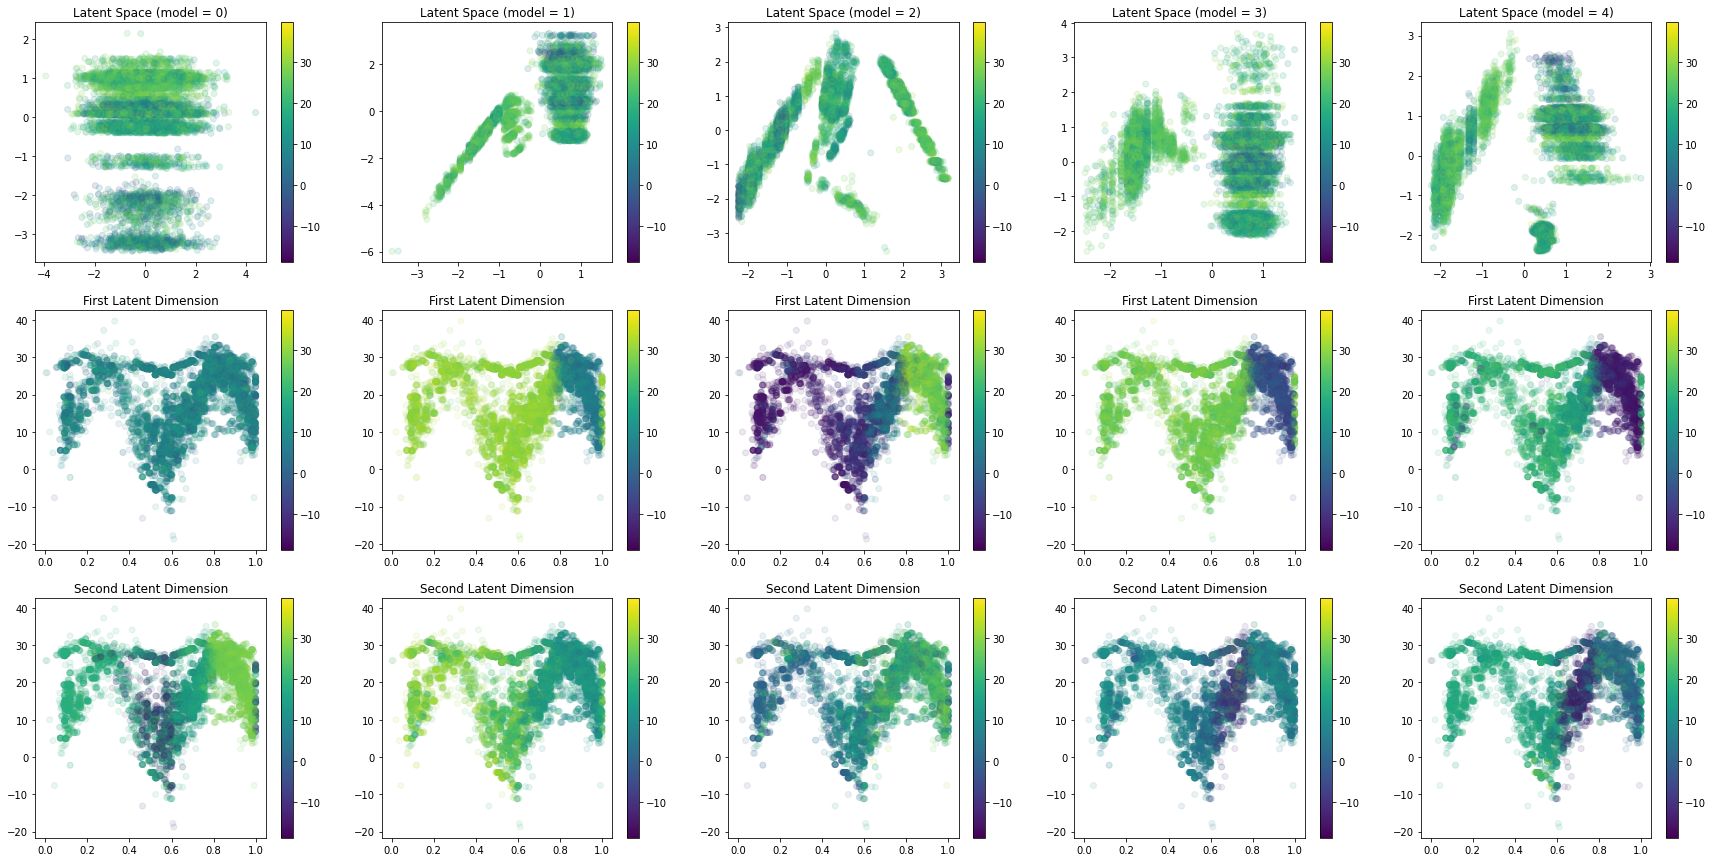

In [30]:
ig,axs = plt.subplots(3,nfolds,figsize=(30,15))

for k,vr in enumerate(RepresentationContainer):
    
    VariationalRepresentation = vr
    im = axs[0,k].scatter(VariationalRepresentation[:,0],VariationalRepresentation[:,1],c=temperatureTest,alpha=0.15)
    axs[0,k].title.set_text('Latent Space (model = ' + str(k) +')')
    cbar = plt.colorbar(im,ax = axs[0,k])
    cbar.solids.set(alpha=1)
    
    axs[1,k].scatter(MetaData.loc[XtestDS.index.tolist()]['outbreaktime'],temperatureTest,c=VariationalRepresentation[:,0],alpha=0.1)
    axs[1,k].title.set_text('First Latent Dimension')
    cbar = plt.colorbar(im,ax = axs[1,k])
    cbar.solids.set(alpha=1)
    
    axs[2,k].scatter(MetaData.loc[XtestDS.index.tolist()]['outbreaktime'],temperatureTest,c=VariationalRepresentation[:,1],alpha=0.1)
    axs[2,k].title.set_text('Second Latent Dimension')
    cbar = plt.colorbar(im,ax = axs[2,k])
    cbar.solids.set(alpha=1)

## Pressure

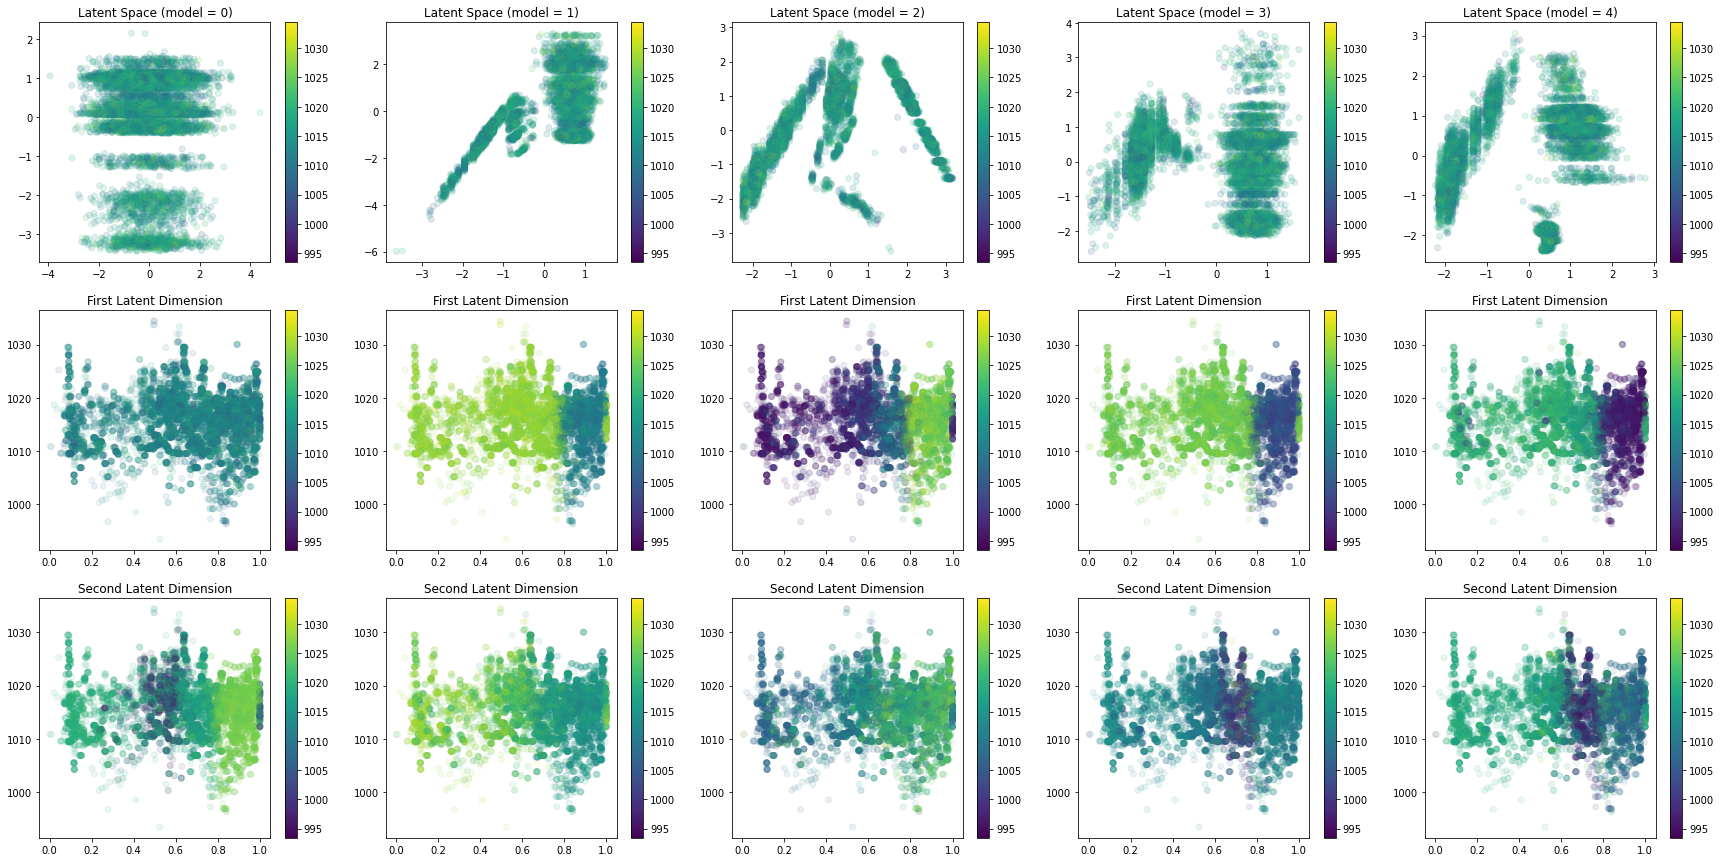

In [31]:
ig,axs = plt.subplots(3,nfolds,figsize=(30,15))

for k,vr in enumerate(RepresentationContainer):
    
    VariationalRepresentation = vr
    im = axs[0,k].scatter(VariationalRepresentation[:,0],VariationalRepresentation[:,1],c=pressureTest,alpha=0.15)
    axs[0,k].title.set_text('Latent Space (model = ' + str(k) +')')
    cbar = plt.colorbar(im,ax = axs[0,k])
    cbar.solids.set(alpha=1)
    
    axs[1,k].scatter(MetaData.loc[XtestDS.index.tolist()]['outbreaktime'],pressureTest,c=VariationalRepresentation[:,0],alpha=0.1)
    axs[1,k].title.set_text('First Latent Dimension')
    cbar = plt.colorbar(im,ax = axs[1,k])
    cbar.solids.set(alpha=1)
    
    axs[2,k].scatter(MetaData.loc[XtestDS.index.tolist()]['outbreaktime'],pressureTest,c=VariationalRepresentation[:,1],alpha=0.1)
    axs[2,k].title.set_text('Second Latent Dimension')
    cbar = plt.colorbar(im,ax = axs[2,k])
    cbar.solids.set(alpha=1)

## Dry air density 

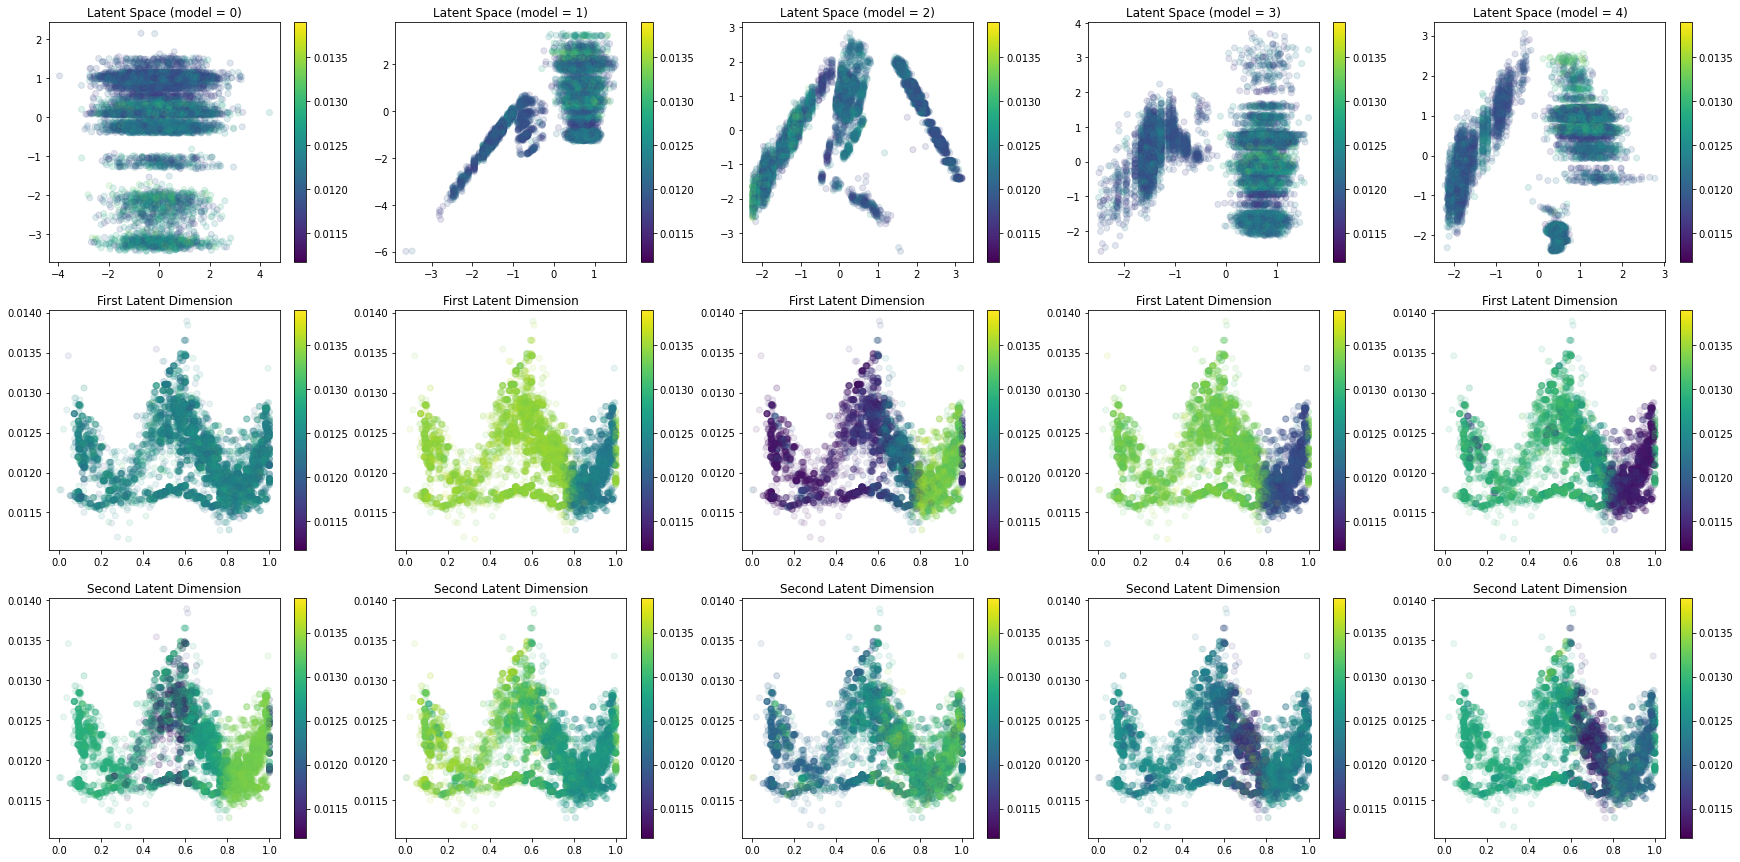

In [32]:
ig,axs = plt.subplots(3,nfolds,figsize=(30,15))

for k,vr in enumerate(RepresentationContainer):
    
    VariationalRepresentation = vr
    im = axs[0,k].scatter(VariationalRepresentation[:,0],VariationalRepresentation[:,1],c=DryAirDensity,alpha=0.15)
    axs[0,k].title.set_text('Latent Space (model = ' + str(k) +')')
    cbar = plt.colorbar(im,ax = axs[0,k])
    cbar.solids.set(alpha=1)
    
    axs[1,k].scatter(MetaData.loc[XtestDS.index.tolist()]['outbreaktime'],DryAirDensity,c=VariationalRepresentation[:,0],alpha=0.1)
    axs[1,k].title.set_text('First Latent Dimension')
    cbar = plt.colorbar(im,ax = axs[1,k])
    cbar.solids.set(alpha=1)
    
    axs[2,k].scatter(MetaData.loc[XtestDS.index.tolist()]['outbreaktime'],DryAirDensity,c=VariationalRepresentation[:,1],alpha=0.1)
    axs[2,k].title.set_text('Second Latent Dimension')
    cbar = plt.colorbar(im,ax = axs[2,k])
    cbar.solids.set(alpha=1)

It's worth pointing out that at least two environmental variables are cyclical, and it can create a confounding effect. Yet, clear patterns are visible and at least two questions can be raised from this data. Do changes in the environment drives SARS Cov 2 mutation or adaptation? or, Do SARS Cov 2 mimics environmental adaptations of the host?